#IMB Employee Attrition Analysis by Category

----------
## Set Up Dataset

In [1]:
from pandas import read_csv
data = read_csv("HR_Attrition.csv")

In [2]:
target = "Attrition"

In [4]:
feature_by_dtype = {}
for c in data.columns:
    
    if c == target: continue
    
    data_type = str(data[c].dtype)
    
    if data_type not in feature_by_dtype.keys():
         feature_by_dtype[data_type] = [c]
    else:
        feature_by_dtype[data_type].append(c)

In [5]:
objects = feature_by_dtype["object"]

In [6]:
remove = ["Over18"]

In [7]:
categorical_features = [f for f in objects if f not in remove]

In [8]:
int64s = feature_by_dtype["int64"]

In [9]:
remove.append("StandardHours")
remove.append("EmployeeCount")

In [10]:
count_features = []
for i in [i for i in int64s if len(data[i].unique()) < 10 and i not in remove]:
    count_features.append(i)

In [10]:
#count_features = count_features + ["TotalWorkingYears", "YearsAtCompany", "HourlyRate"]

In [11]:
data[count_features].head()

,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance
0,2,2,3,2,4,3,1,0,0,1
1,1,3,2,2,2,4,4,1,3,3
2,2,4,2,1,3,3,2,0,3,3
3,4,4,3,1,3,3,3,0,3,3
4,1,1,3,1,2,3,4,1,3,3


In [12]:
data[categorical_features].head()

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
0,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Yes
1,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,No
2,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Yes
3,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Yes
4,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,No


----------


# Chi-square 2 Way 

In [13]:
from scipy.stats import chi2_contingency
from pandas import crosstab, DataFrame

p_value_table = DataFrame(index = [target], columns = (categorical_features+count_features))

for c in (categorical_features+count_features):

    crosstable = crosstab(data[c], data[target])
    chi2, p, dof, expected = chi2_contingency(crosstable)
    p_value_table[c][target] = p

p_value_table = p_value_table.T
p_value_table["p < 0.05"] = p_value_table.apply(lambda x : x < 0.05)

In [14]:
p_value_table.sort_values("Attrition", ascending=False)

,Attrition,p < 0.05
PerformanceRating,0.990075,False
Education,0.545525,False
Gender,0.290572,False
RelationshipSatisfaction,0.154972,False
TrainingTimesLastYear,0.0191477,True
EducationField,0.00677398,True
Department,0.00452561,True
WorkLifeBalance,0.00097257,True
JobSatisfaction,0.0005563,True
EnvironmentSatisfaction,5.12347e-05,True


Attrition's Non-Significant Categorical Relationships

In [15]:
ns = p_value_table[p_value_table["p < 0.05"] == False].index.tolist()
print(ns)

['Gender', 'Education', 'PerformanceRating', 'RelationshipSatisfaction']


Attrition's Statistically Significant Categorical Relationships

In [16]:
significant = p_value_table[p_value_table["p < 0.05"] == True].index.tolist()
print(significant)

['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus', 'OverTime', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance']


----------
# Count Plots

In [17]:
def percentages(data,category, filter_):
    output = {}
    total_count = data[filter_][category].value_counts().sum()
    for subclass in data[filter_][category].unique():
        subclass_count = data[filter_][category].value_counts()[subclass]
        output[subclass] = (subclass_count / total_count) * 100
    return output

from IPython.display import display
from pandas import DataFrame, options

def display_percentages(data,category, filter_):
    perc = percentages(data,category, filter_)
    df = DataFrame(perc, index=["Percent"]).T.sort_values("Percent", ascending=False)
    df["Cumulative Percent"] = [df["Percent"][0:i].sum() for i in range(1,len(df)+1)]
    options.display.float_format = '{:,.1f}%'.format
    print("Yes Only")
    print("Total Count: %s" % len(data[filter_]))
    display(df)
    
#====

from seaborn import countplot, despine, axes_style, set_style
from matplotlib.pyplot import show,figure,subplot,xticks,suptitle,title, ylabel, xlabel, margins
from numpy import mean

def display_categorical_x_categorical_analysis(data,category):

    set_style("whitegrid")

    with axes_style({'grid.color': "0.95", "lines.color" : "0.95"}):

        c = category

        order = data[data[target] == "Yes"][c].value_counts().sort_values(ascending=False).index

        fig = figure(figsize=(12,6))
        suptitle(c, fontsize=16)
        margins(0.8)
        subplot(121)
        title("Yes Only")
        cp = countplot(x=c, data=data[data[target] == "Yes"], order=order, color="#121831", linewidth=0)
        despine(left=True, top=True)

        xlabel_char_length = int(mean([len(str(i)) for i in data[c].unique()]))

        if(xlabel_char_length in range(7, 15)): 
            xticks(rotation=45)
        elif(xlabel_char_length > 14):
            xticks(rotation=90)

        subplot(122)
        title("Yes vs No")
        cp = countplot(x=c, hue=target, data=data, order=order, palette=["#121831", "#d4e2ed"], linewidth=0)
        despine(left=True, top=True)
        if(xlabel_char_length in range(7, 15)): 
            xticks(rotation=45)
        elif(xlabel_char_length > 14):
            xticks(rotation=90)
        xlabel(c)
        show()

        display_percentages(data,c,data[target] == "Yes")

F:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [18]:
i = iter(significant)

# Majority of employees lost in attrition rarely travel.

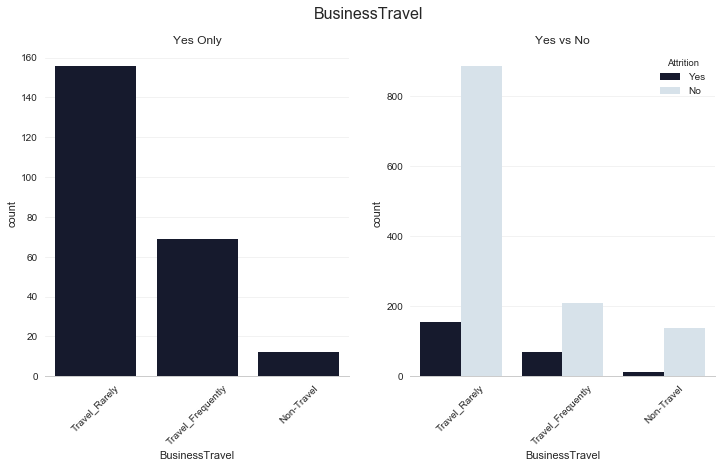

Yes Only
Total Count: 237


,Percent,Cumulative Percent
Travel_Rarely,65.8%,65.8%
Travel_Frequently,29.1%,94.9%
Non-Travel,5.1%,100.0%


In [19]:
display_categorical_x_categorical_analysis(data,next(i))

# Research & Development and Sales department contribute ~95% of the employees lost in attrition

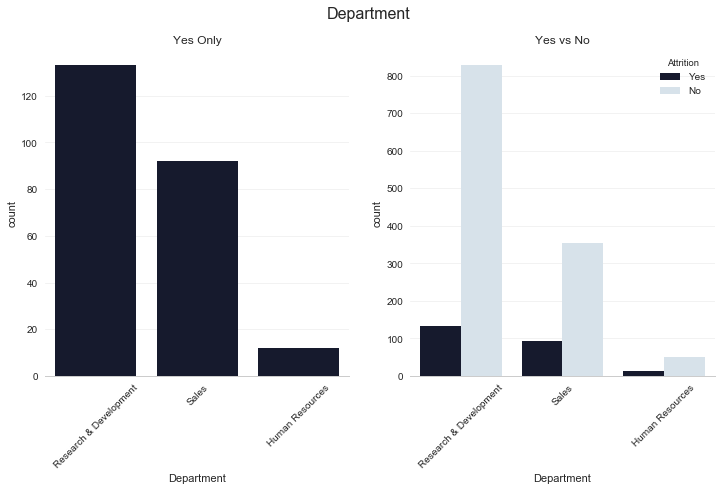

Yes Only
Total Count: 237


,Percent,Cumulative Percent
Research & Development,56.1%,56.1%
Sales,38.8%,94.9%
Human Resources,5.1%,100.0%


In [20]:
display_categorical_x_categorical_analysis(data,next(i))

# Employees educated in life sciences or medical together make up ~64% of the attrition sample.

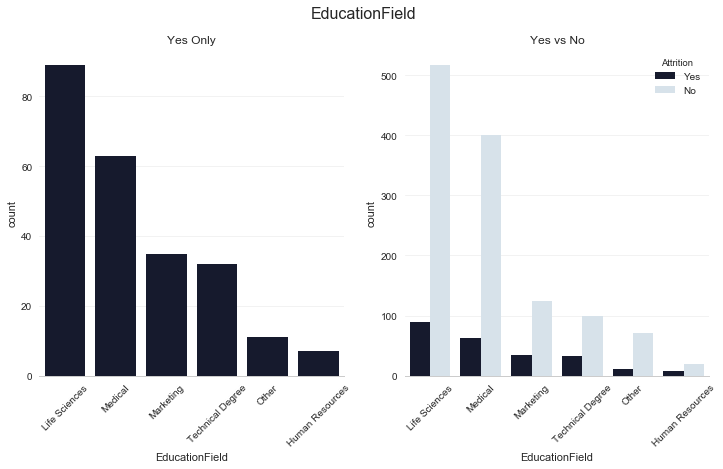

Yes Only
Total Count: 237


,Percent,Cumulative Percent
Life Sciences,37.6%,37.6%
Medical,26.6%,64.1%
Marketing,14.8%,78.9%
Technical Degree,13.5%,92.4%
Other,4.6%,97.0%
Human Resources,3.0%,100.0%


In [21]:
display_categorical_x_categorical_analysis(data,next(i))

# 70% of attrition sample is made up from laboratory technicians,  sale executives, and research scientists.

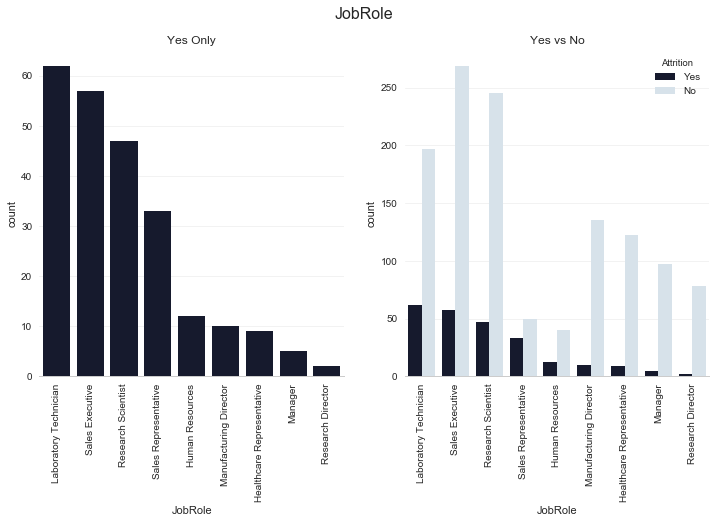

Yes Only
Total Count: 237


,Percent,Cumulative Percent
Laboratory Technician,26.2%,26.2%
Sales Executive,24.1%,50.2%
Research Scientist,19.8%,70.0%
Sales Representative,13.9%,84.0%
Human Resources,5.1%,89.0%
Manufacturing Director,4.2%,93.2%
Healthcare Representative,3.8%,97.0%
Manager,2.1%,99.2%
Research Director,0.8%,100.0%


In [22]:
display_categorical_x_categorical_analysis(data,next(i))

# Employees with the relationship status as single make up over 50% attrition sample.

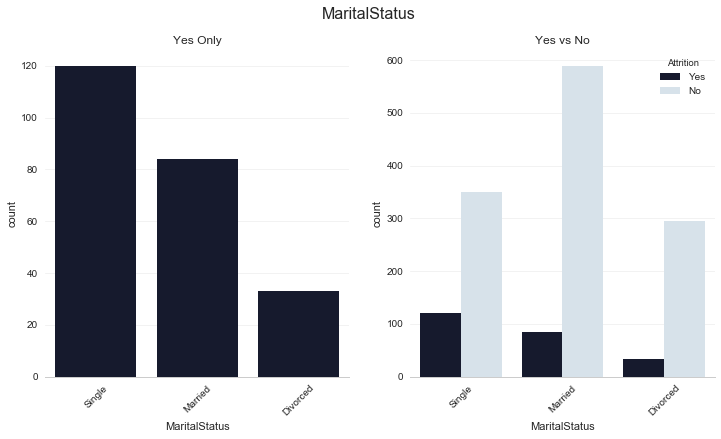

Yes Only
Total Count: 237


,Percent,Cumulative Percent
Single,50.6%,50.6%
Married,35.4%,86.1%
Divorced,13.9%,100.0%


In [23]:
display_categorical_x_categorical_analysis(data,next(i))

# The ratio of employees working overtime is drastically different across Yes vs No samples. 

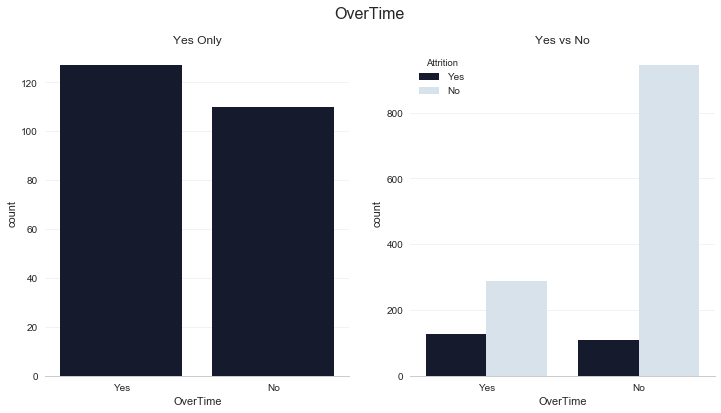

Yes Only
Total Count: 237


,Percent,Cumulative Percent
Yes,53.6%,53.6%
No,46.4%,100.0%


In [24]:
display_categorical_x_categorical_analysis(data,next(i))

# The distribution of environment satisfaction ratings are different for employees lost in attrition vs those who stayed. 

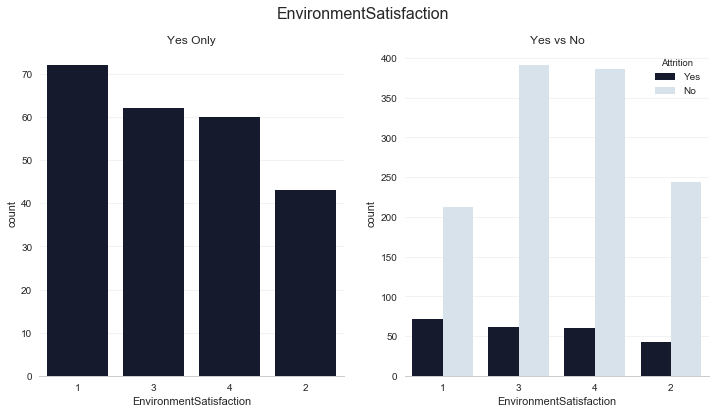

Yes Only
Total Count: 237


,Percent,Cumulative Percent
1,30.4%,30.4%
3,26.2%,56.5%
4,25.3%,81.9%
2,18.1%,100.0%


In [25]:
display_categorical_x_categorical_analysis(data,next(i))

# ~80% of employees lost in attrition rated their level job involvement as moderate to moderately high.

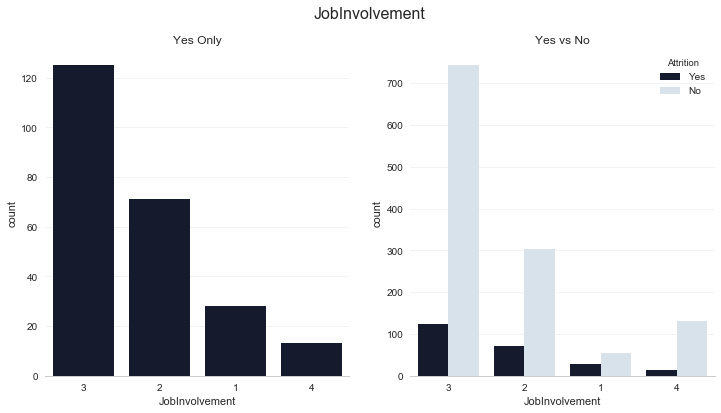

Yes Only
Total Count: 237


,Percent,Cumulative Percent
3,52.7%,52.7%
2,30.0%,82.7%
1,11.8%,94.5%
4,5.5%,100.0%


In [26]:
display_categorical_x_categorical_analysis(data,next(i))

# Entry level employees make up 60% of the attrition sample

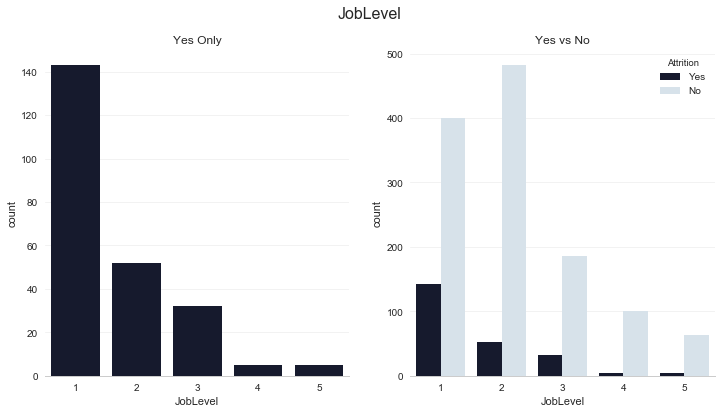

Yes Only
Total Count: 237


,Percent,Cumulative Percent
1,60.3%,60.3%
2,21.9%,82.3%
3,13.5%,95.8%
4,2.1%,97.9%
5,2.1%,100.0%


In [27]:
display_categorical_x_categorical_analysis(data,next(i))

# Employees who stay had job satisfactions ratings ratio more positively biased than those lost in attrition.

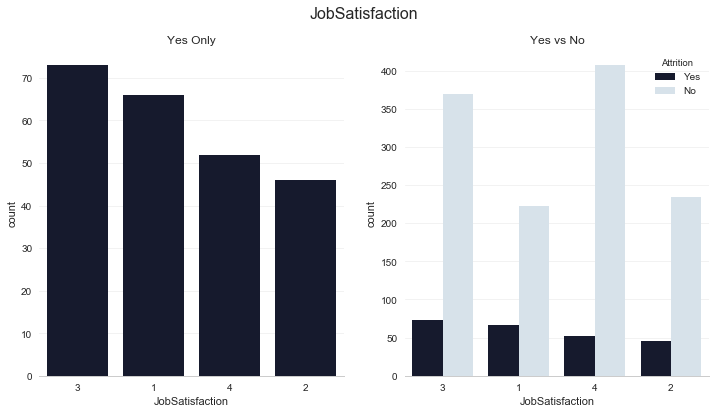

Yes Only
Total Count: 237


,Percent,Cumulative Percent
3,30.8%,30.8%
1,27.8%,58.6%
4,21.9%,80.6%
2,19.4%,100.0%


In [28]:
display_categorical_x_categorical_analysis(data,next(i))

# Employees lost in attrition had 65% of its members possessing stock option level at 0.

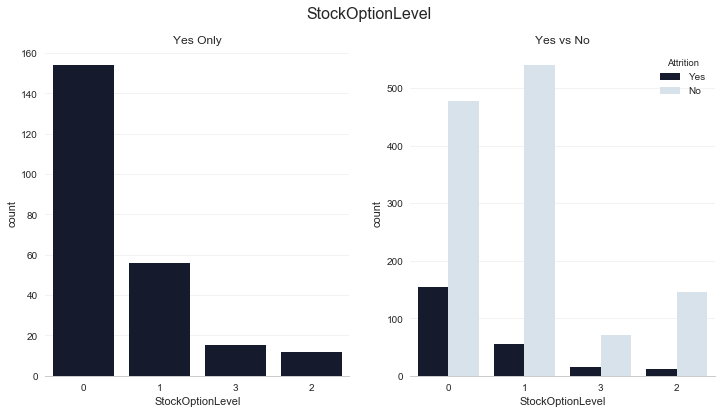

Yes Only
Total Count: 237


,Percent,Cumulative Percent
0,65.0%,65.0%
1,23.6%,88.6%
3,6.3%,94.9%
2,5.1%,100.0%


In [29]:
display_categorical_x_categorical_analysis(data,next(i))

# Employees lost in attrition had ~70% of members trained 2 - 3 times a year. 

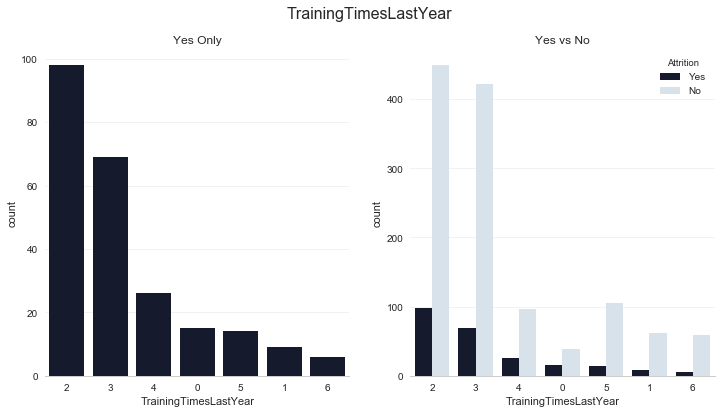

Yes Only
Total Count: 237


,Percent,Cumulative Percent
2,41.4%,41.4%
3,29.1%,70.5%
4,11.0%,81.4%
0,6.3%,87.8%
5,5.9%,93.7%
1,3.8%,97.5%
6,2.5%,100.0%


In [30]:
display_categorical_x_categorical_analysis(data,next(i))

# ~78% of employees lost in attrition rated their worklife balance as moderate to moderately high.

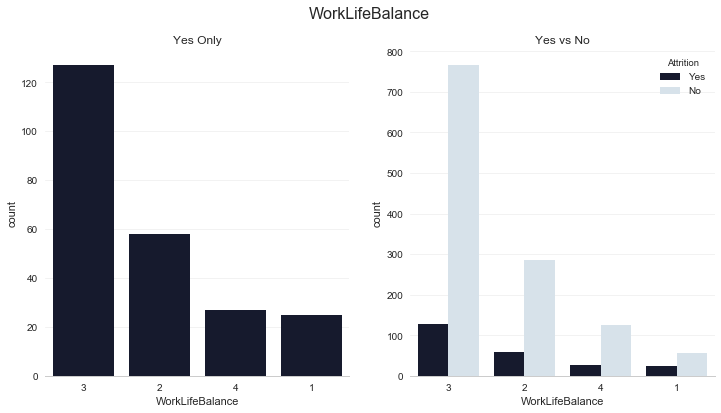

Yes Only
Total Count: 237


,Percent,Cumulative Percent
3,53.6%,53.6%
2,24.5%,78.1%
4,11.4%,89.5%
1,10.5%,100.0%


In [31]:
display_categorical_x_categorical_analysis(data,next(i))

----------

### Read more:
- [IBM Employee Attrition Analysis by Numerics][1]
  [1]: https://www.kaggle.com/slamnz/d/pavansubhasht/ibm-hr-analytics-attrition-dataset/ibm-employee-attrition-analysis-by-numerics/